In [0]:
%matplotlib inline
from fastai.basics import *

In [0]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-07-27 06:55:46--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  5.95MB/s    in 2.6s    

2019-07-27 06:55:49 (5.95 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
!gzip -d mnist.pkl.gz

gzip: mnist.pkl.gz: No such file or directory


In [0]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

torch.Size([50000, 784])

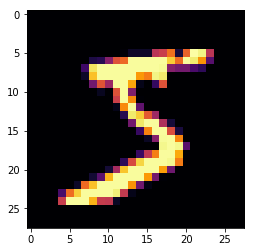

In [0]:
plt.imshow(x_train[0].reshape((28,28)),cmap="inferno")
x_train.shape

In [0]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [0]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [0]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [0]:
model = Mnist_Logistic().cuda()

In [0]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [0]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [0]:
model(x).shape

torch.Size([64, 10])

In [0]:
lr=2e-2

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

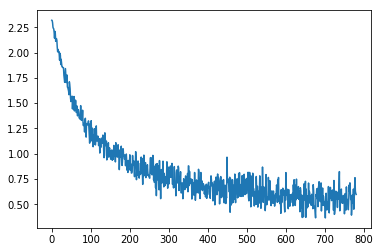

In [0]:
plt.plot(losses)

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
losses = [update(x,y,lr) for x,y in data.train_dl]

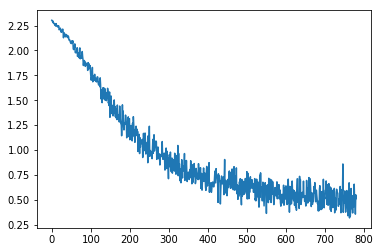

In [0]:
plt.plot(losses)

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


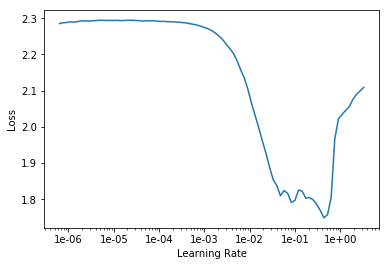

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.144134,0.137222,0.959400,00:03


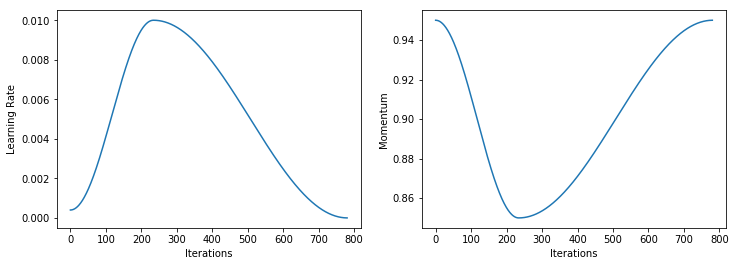

In [54]:
learn.recorder.plot_lr(show_moms=True)

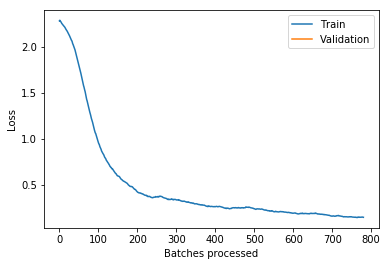

In [55]:
learn.recorder.plot_losses()